# Set up the problem

In [30]:
%matplotlib inline

import numpy as np
import scipy.stats as stats
import os
from copy import deepcopy

from scipy.special import gammaln
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import delfi.generator as dg
import delfi.distribution as dd
from delfi.utils.viz import plot_pdf, probs2contours
import delfi.inference as infer
from delfi.summarystats.Identity import Identity

from snl.util.plot import plot_hist_marginals
from lfimodels.snl_exps.util import  save_results_byname, load_results_byname
from lfimodels.rockpaperscissors.rps_sde import rps_sde

n_cores = 8

model_id = 'rps'
save_path = 'results/' + model_id

seed = 4200

L = 100  # image rows/columns
duration = 100.0
dt = 1.0

nseeds = 20

use_maf = False

In [138]:
# simulation setup
setup_opts = {
    'n_bypass': 0,
    'filter_sizes': [3,3,3,3, 2, 2],
    'n_filters':    (8,8,8,16,32,32),
    'pool_sizes':   [1,3,2,2, 2, 1],
    'n_hiddens': [50, 50],
    'reg_lambda': 0.01,
    'pilot_samples': 0,  # values are already between 0 and 1
    'verbose': True,
    'prior_norm': False,  # turn off till we've fixed the active trainer. good for uniform priors etc.
    'init_norm': False,
    'input_shape': (3,L,L),
    'verbose': True,
}
if use_maf:
    setup_opts.update(dict(density='maf', maf_mode='random', n_mades=5, maf_actfun='tanh', batch_norm=False))
else:
    setup_opts.update(dict(density='mog', n_components=1))                 

run_opts = {
    'n_train': 1000,
    'n_rounds': 10,
    'minibatch': 100,
    'epochs': 2000,
    'moo': 'resample',
    'proposal': 'discrete',
    'n_null': None,
    'train_on_all': True,
    'max_norm': 0.1,
    'val_frac': 0.1,
    'silent_fail': False,
}

prior_lower = np.array([-1, -1, -6])
prior_upper = np.array([1,  1,   -5])

In [3]:
# define a function for showing simulation results as images
def showsim(s_rgb, L=100, **kwargs):
    if 'interpolation' not in kwargs.keys():
        kwargs['interpolation'] = 'None'
    s_ryb = s_rgb.copy().reshape(3, L, L)
    s_ryb[0] = np.minimum(1.0, s_ryb[0] + s_ryb[1])
    imobj = plt.imshow(np.moveaxis(s_ryb, 0, -1), **kwargs)
    plt.gca().axis('off')
    return imobj

In [ ]:
def init_all(seed, pars_true=None, infobj=infer.SNPEC, svi=False):
    p = dd.Uniform(lower=prior_lower, dtype=float), 
                   upper=prior_upper, dtype=float), seed=seed)    
    mlist = [rps_sde(dt=dt, duration=duration, L=L, seed=seed + 100 + i) for i in range(n_cores)]
    g = dg.MPGenerator(models=mlist, prior=p, summary=Identity(seed=seed+2), seed=seed+3)
    
    if pars_true is None:
        pars_true = g.prior.gen(1).reshape(-1)
    #obs = g.model.gen_single(pars_true)
    obs = g.models[0].gen_single(pars_true)
    obs_stats = g.summary.calc([obs])
    
    if setup_opts['density'] == 'mog':
        setup_opts['svi'] = svi
    
    inf = infobj(generator=g, obs=obs_stats, seed=seed+4, **setup_opts)
    
    return g, pars_true, obs, obs_stats, inf

### At this point, we can skip to loading results below if we already have them saved

# Run multiple seeds for APT, SNPE-A and SNPE-B

In [ ]:
seeds = seed + np.arange(nseeds) * 20

In [ ]:
# run multiple seeds with SNPEC discrete MDN
for s in seeds:
    _, pt, raw_data, stats, nextinf = init_all(s)  # samples observed data from the marginal (i.e. with parameters from the prior)
    ll, _, pp = nextinf.run(**run_opts)
    
    exp_id = 'rps_' + setup_opts['density'] + '_' + str(s)
    save_results_byname(logs=ll, posteriors=pp, raw_data=raw_data, pars_true=pt, seed=s,
                        setup_opts=setup_opts, run_opts=run_opts, exp_id=exp_id, path=save_path)

In [ ]:
run_opts_SNPEAB = {
    'n_train': 1000,
    'n_rounds': 10,
    'minibatch': 100,
    'epochs': 2000,
    'max_norm': 0.1,
    'val_frac': 0.1,
}

In [ ]:
# run multiple seeds with SNPEA MDN
for s in seeds:
    
    _, pt, raw_data, stats, nextinf = init_all(s, infobj=infer.CDELFI)  # samples observed data from the marginal (i.e. with parameters from the prior)
    ll, _, pp = nextinf.run(**run_opts_SNPEAB)
    
    exp_id = 'rps_' + setup_opts['density'] + '_' + str(s) + '_A'
    save_results_byname(logs=ll, posteriors=pp, raw_data=raw_data, pars_true=pt, seed=s,
                        setup_opts=setup_opts, run_opts=run_opts, exp_id=exp_id, path=save_path)

In [ ]:
# run multiple seeds with SNPEB MDN
for s in seeds:
    
    _, pt, raw_data, stats, nextinf = init_all(s, infobj=infer.SNPE, svi=True)  # samples observed data from the marginal (i.e. with parameters from the prior)
    ll, _, pp = nextinf.run(**run_opts_SNPEAB)
    
    exp_id = 'rps_' + setup_opts['density'] + '_' + str(s) + '_B'
    save_results_byname(logs=ll, posteriors=pp, raw_data=raw_data, pars_true=pt, seed=s,
                        setup_opts=setup_opts, run_opts=run_opts, exp_id=exp_id, path=save_path)

# Load results from disk for all seeds/algorithms we've run

In [4]:
#load results
subdirs = os.listdir(save_path)
exp_ids, exp_ids_A, exp_ids_B = [], [], []
for d in subdirs:
    if not d.startswith('rps_'):
        continue
    if d.endswith('_A'):
        exp_ids_A.append(d)
    elif d.endswith('_B'):
        exp_ids_B.append(d)
    else:
        exp_ids.append(d)
        
posteriors_seeds, pars_true_seeds, raw_data_seeds = [], [], []
for exp_id in exp_ids:
    pp, load_vars = load_results_byname(exp_id, path=save_path)
    posteriors_seeds.append(pp)
    pars_true_seeds.append(np.array(load_vars['pars_true']))
    raw_data_seeds.append(load_vars['raw_data']['data'])
Pmat = np.array([[-pp.eval(pt.reshape(1, -1), log=True)[0] for pp in P] for P, pt in zip (posteriors_seeds, pars_true_seeds)]).T
    
posteriors_seeds_A, pars_true_seeds_A = [], []
for exp_id in exp_ids_A:
    pp, load_vars = load_results_byname(exp_id, path=save_path)
    pp_ok = []
    for nextp in pp:
        if nextp is None:
            pp_ok.append(pp_ok[-1])
        else:
            pp_ok.append(nextp)
    posteriors_seeds_A.append(pp_ok)
    pars_true_seeds_A.append(np.array(load_vars['pars_true']))
Pmat_A = np.array([[-pp.eval(pt.reshape(1, -1), log=True)[0] for pp in P] for P, pt in zip (posteriors_seeds_A, pars_true_seeds_A)]).T

posteriors_seeds_B, pars_true_seeds_B = [], []
for exp_id in exp_ids_B:
    pp, load_vars = load_results_byname(exp_id, path=save_path)
    posteriors_seeds_B.append(pp)
    pars_true_seeds_B.append(np.array(load_vars['pars_true']))
Pmat_B = np.array([[-pp.eval(pt.reshape(1, -1), log=True)[0] for pp in P] for P, pt in zip (posteriors_seeds_B, pars_true_seeds_B)]).T

In [5]:
# calculate means and standard errors of the mean
sem = Pmat.std(axis=1) / np.sqrt(Pmat.shape[1] - 1)
meanlog = Pmat.mean(axis=1)
sem_A = Pmat_A.std(axis=1) / np.sqrt(Pmat_A.shape[1] - 1)
meanlog_A = Pmat_A.mean(axis=1)
sem_B = Pmat_B.std(axis=1) / np.sqrt(Pmat_B.shape[1] - 1)
meanlog_B = Pmat_B.mean(axis=1)

# Make the figure

In [171]:
# store posterior samples and marginals etc.
n_posterior_samples = 3
seed_indices = [9, 16, 26, 29] # 24
seed_colors = ['b', 'm', 'orange', 'lime']
seed_labels = ['i', 'ii', 'iii', 'iv']
figgen_seed = 1
n_bins = 500  # for posterior plotting

contour_levels = (0.6826894921370859,)  # 1 s.d.

model = rps_sde(dt=dt, duration=duration, L=L, seed=figgen_seed)

# store posterior samples
posterior_samples = []
for iseed in seed_indices:
    pp = posteriors_seeds[iseed][-1]
    posterior_samples.append(np.stack([x[0]['data'] for x in model.gen(pp.gen(n_posterior_samples))], axis=0))

# store posterior marginals
xx = []
for i in range(model.dim_param):
    xx.append(np.linspace(prior_lower[i], prior_upper[i], n_bins))

posterior_xx = []
for i in range(model.dim_param):
    posterior_xx.append([])
    for iseed in seed_indices:
        pp = posteriors_seeds[iseed][-1]    
        posterior_xx[i].append(pp.eval(xx[i], ii=[i], log=False))

aa = np.linspace(0.0, 2.0 * np.pi, n_bins)
cs = np.stack((np.cos(aa), np.sin(aa)), axis=0)
# store posterior 2-way marginal contours
contour_xy = []
for i in range(model.dim_param):
    contour_xy.append([])    
    for j in range(i):
        contour_xy[i].append([])        
        for iseed in seed_indices:
            idims = [i, j]
            pp = posteriors_seeds[iseed][-1].project_to_gaussian()
            C = np.linalg.cholesky(pp.S[idims, :][:, idims])
            contour_xy[i][j].append(np.dot(C, cs) + pp.m[idims].reshape(-1, 1))

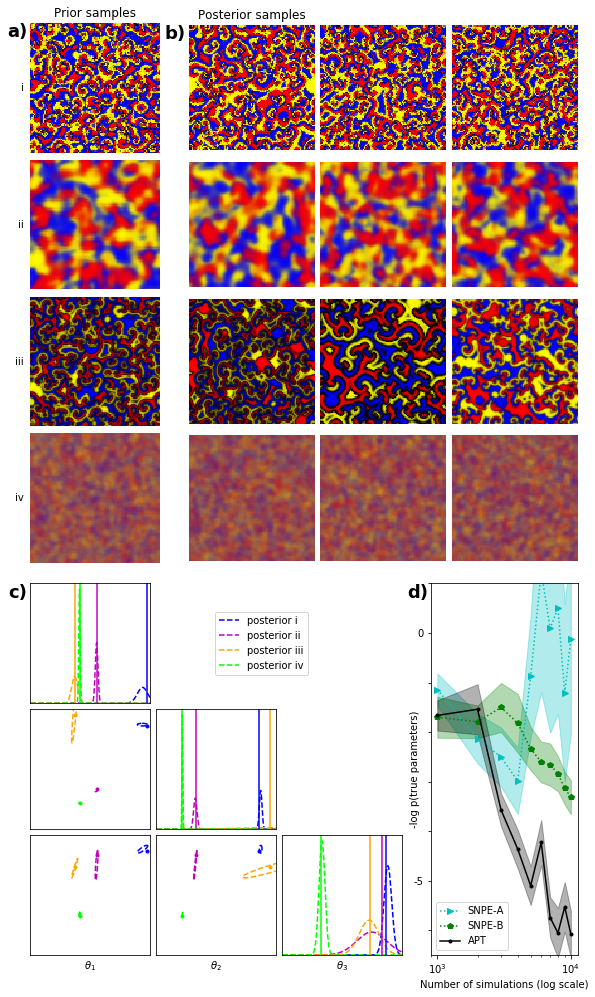

In [208]:
plotfun = plt.semilogx

nrows = len(seed_indices)

nsim = (np.arange(run_opts['n_rounds']) + 1.0) * run_opts['n_train']

figsize = (8.0, 14.0)  # width, height
figar = figsize[0] / figsize[1]

left_subfig = 0.05
right_subfig = 1.0
bottom_subfig = 0.05
top_subfig = 0.975
wspace_subfig = 0.05
hspace_subfig = 0.02
wspace_rows = 0.05
hspace_rows = 0.05
graph_height = 3 / (nrows + 3)

def print_subfig_label(s, leftoffset=0.005):
    ax = plt.gca()
    boundingbox = ax.get_position()
    axwidth = boundingbox.xmax - boundingbox.xmin  # fraction of figure width
    plt.text(-leftoffset / axwidth, 1., s, fontsize = 18, weight='bold',
             transform=ax.transAxes,
             horizontalalignment='right', verticalalignment='top')

subfig_wspace = right_subfig - left_subfig - wspace_subfig
right_prior = left_subfig + subfig_wspace / (1 + n_posterior_samples)

fig_rps = plt.figure(figsize=figsize)
# a) prior samples, b) posterior samples, c) posteriors, d) log p(true)
gs_a = gridspec.GridSpec(nrows, 1, figure=fig_rps,
                         left=left_subfig, right=right_prior,
                         bottom=graph_height + hspace_subfig / 2, top=top_subfig,
                         hspace=hspace_rows, wspace=wspace_rows)
gs_b = gridspec.GridSpec(nrows, n_posterior_samples, figure=fig_rps,
                         left=right_prior + wspace_subfig, right=right_subfig,
                         bottom=graph_height + hspace_subfig / 2, top=top_subfig,
                         hspace=hspace_rows, wspace=wspace_rows)
c_width = (graph_height - hspace_subfig / 2 - bottom_subfig) / figar
gs_c = gridspec.GridSpec(model.dim_param, model.dim_param, figure=fig_rps,
                         left=left_subfig, right=left_subfig + c_width,  # keep aspect ratio to 1
                         bottom=bottom_subfig, top=graph_height - hspace_subfig / 2,
                         hspace=hspace_rows, wspace=wspace_rows)

d_left = left_subfig + c_width + wspace_subfig
ax_d = plt.axes((d_left,
                 bottom_subfig,
                 right_subfig - d_left,
                 graph_height - hspace_subfig / 2 - bottom_subfig))

for j, iseed in enumerate(seed_indices):
    
    ax = plt.subplot(gs_a[j, 0])
    showsim(raw_data_seeds[iseed], L=L)  # prior sample
    plt.text(-0.05, 0.5, seed_labels[j], transform=ax.transAxes,
             horizontalalignment='right', verticalalignment='center')
    if j == 0:
        print_subfig_label('a)')
        plt.title('Prior samples')
    
    for k, d in enumerate(posterior_samples[j]):
        ax = plt.subplot(gs_b[j, k])
        showsim(d, L=L)
        if j == 0 and k == 0:
            print_subfig_label('b)')  
            plt.title('Posterior samples')

# plot true params and posteriors for the seeds above
for i in range(model.dim_param):
    for j in range(i + 1):        
        ax = plt.subplot(gs_c[i, j])
        if i == 0 and j == 0:
            print_subfig_label('c)')
            
        for k in range(nrows):
            if i == j:            
                plt.plot(xx[i], posterior_xx[i][k], '--', color=seed_colors[k], label='posterior ' + seed_labels[k])                
            else:
                plt.plot(contour_xy[i][j][k][1,:], contour_xy[i][j][k][0,:], '--', color=seed_colors[k])
       
        if i == j:
            plt.xlim(prior_lower[i], prior_upper[i])
            YL = list(plt.ylim())
            YL[0] = np.maximum(YL[0], 0.0)
            for k, iseed in enumerate(seed_indices):
                plt.plot(np.ones(2) * pars_true_seeds[iseed][i], YL, color=seed_colors[k])
            plt.ylim(YL)            
            if i == 0:
                ax.legend(loc='center left', bbox_to_anchor=(1.5, 0.5))
        else:
            for k, iseed in enumerate(seed_indices):
                plt.plot(pars_true_seeds[iseed][j], pars_true_seeds[iseed][i], '.', color=seed_colors[k])
            plt.xlim(prior_lower[j], prior_upper[j])
            plt.ylim(prior_lower[i], prior_upper[i])
            
        plt.yticks([], [])
        if i != model.dim_param - 1:
            plt.xticks([], [])
        else:
            plt.xticks([], [])
            #plt.xticks((prior_lower[j], prior_upper[j]))
            plt.xlabel('$\\theta_{0}$'.format(j+1))
            
# plot mean and SEM over seeds of log posterior probability of true params
plt.sca(ax_d)
print_subfig_label('d)')
plt.fill_between(nsim, meanlog_A-sem_A, meanlog_A+sem_A, color='c', alpha=0.3)
plt.fill_between(nsim, meanlog_B-sem_B, meanlog_B+sem_B, color='g', alpha=0.3)
plt.fill_between(nsim, meanlog-sem, meanlog+sem, color='k', alpha=0.3)
hA = plotfun(nsim, Pmat_A.mean(axis=1),'c>:', label='SNPE-A')
hB = plotfun(nsim, Pmat_B.mean(axis=1),'gp:', label='SNPE-B')
h = plotfun(nsim, Pmat.mean(axis=1),'k.-', label='APT')

plt.ylim((-6.5, 1))

plt.ylabel('-log p(true parameters)', labelpad=-6)
plt.xlabel('Number of simulations (log scale)')
plt.legend(loc='lower left')

yt_show = [-5, 0]
YTL = ax_d.get_yticks().tolist()
for i in range(len(YTL)):
    if YTL[i] not in yt_show:
        YTL[i] = ''
    else:
        YTL[i] = [z for z in yt_show if z == YTL[i]][0]
ax_d.set_yticklabels(YTL)

plt.show()

In [209]:
# save figure
fig_rps.savefig('fig6.pdf')